# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [52]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import random

# modify to where you store your project data including utils
datadir = "/content/drive/My Drive/Semesters/Semester 7/CS445/MPs/MP4/proj4/" 

utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
inputsfn = datadir + "inputs"
!cp -r "$inputsfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/outputs’: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [55]:
# TODO: Replace this with your path and files

imdir = 'inputs'

imfns = ['200.jpg', '400.jpg', '800.jpg', '1600.jpg', '3200.jpg', '6400.jpg']
exposure_times = [1/200.0, 1/400.0, 1/800.0, 1/1600.0, 1/3200.0, 1/6400.0]
background_image_file = imdir + '/' + 'baseline.jpg'

# Use this for other light map (bells & whistles)
# imfns = ['8.jpg', '10.jpg', '40.jpg', '160.jpg']
# exposure_times = [1/8.0, 1/10.0, 1/40.0, 1/160.0]
# background_image_file = imdir + '/' + 'baseline3.jpg'

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image = read_image(background_image_file)



### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [56]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.


    
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures
            
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)
  
    # TO DO
    # Divide each image by exposure time to find irradiance
    running_sum = np.zeros((H, W, 3))
    log_irradiances = np.zeros_like(ldr_images)

    for i in range(N):
      curr_irradiance = ldr_images[i] / exposures[i]
      curr_log_irradiance = np.log(curr_irradiance)
      log_irradiances[i] = curr_log_irradiance
      running_sum = np.add(running_sum, curr_irradiance)

    # Get average irradiance
    hdr_image = running_sum / N
    return hdr_image, log_irradiances



In [57]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''

    # Log and normalize
    le = np.log(im_hdr)

    # print('le min max', le.min(), le.max())

    le_min = le[le != -float('inf')].min()
    le_max = le[le != float('inf')].max()
    le[le==float('inf')] = le_max
    le[le==-float('inf')] = le_min

    le = (le - le_min) / (le_max - le_min)

    # Some more scaling magic
    # img_out = le / (1.0 + le)


    # Display image
    plt.imshow(le)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


HDR Image


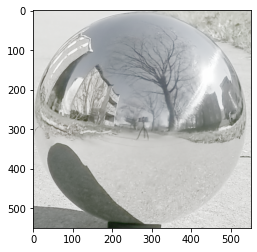

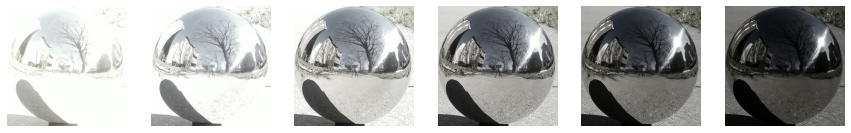

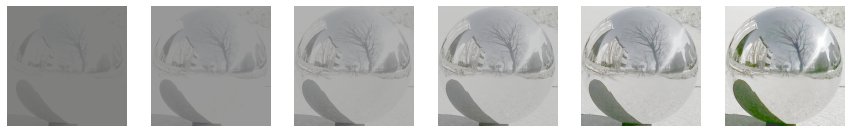

In [58]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [59]:
# this is overcomplicated, but oh well
def get_image_weights(img):
  # weighted_image = np.copy(img)

  # for i in range(img.shape[0]):
  #   for j in range(img.shape[1]):
  #     for k in range(img.shape[2]):
  #       weighted_image[i][j][k] = weighted_image[i][j][k] - 0.5

  # weighted_image = np.abs(weighted_image)
  # weighted_image = -1 * weighted_image

  # for i in range(img.shape[0]):
  #   for j in range(img.shape[1]):
  #     for k in range(img.shape[2]):
  #       weighted_image[i][j][k] = weighted_image[i][j][k] + 0.5

  # return weighted_image
  retval =  np.double(128.0 - np.abs(np.double(img) - 128.0))
  return retval
  
w = lambda z: float(128-abs(z-128))

# clean ldr image by removing values equal to 0 or 255
# must pass in rgb values as 0 to 255 scale, with ints not floats
# doesn't modify original
def clean_ldr_images(ldr_images):
  N, H, W, C = ldr_images.shape
  ldr_images_clean = np.int64(255 * np.copy(ldr_images))
  for n in range(N):
    for h in range(H):
      for w in range(W):
        for c in range(C):
          if (ldr_images_clean[n][h][w][c] == 0):
            ldr_images_clean[n][h][w][c] = 1
          elif (ldr_images_clean[n][h][w][c] == 255):
            ldr_images_clean[n][h][w][c] = 254
  return ldr_images_clean

In [60]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO

    # Compute image weights (closer to 0.5 -> 1.0, closer to 0.0 or 1.0 -> 0.0)
    ldr_images_clean = clean_ldr_images(ldr_images)
    image_weights = np.zeros_like(ldr_images)

    for i in range(N):
      image_weights[i] = get_image_weights(ldr_images_clean[i])
    image_weights_sum = np.sum(image_weights, axis=0)

    # Divide each image weight by exposure time, then multiply by weights
    running_sum = np.zeros((H, W, 3))
    for i in range(N):
      curr_irradiance = ldr_images[i] / exposure_times[i]
      curr_irradiance_times_weights = np.multiply(curr_irradiance, image_weights[i])
      running_sum = np.add(running_sum, curr_irradiance_times_weights)

    # Return weighted image average
    # (A * wA + B * wB + ...) / (wA + wB + ...)
    weighted_average = np.divide(running_sum, image_weights_sum)
    return weighted_average



Weighted HDR image:


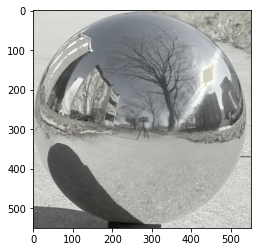

In [61]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

# display HDR image
print("Weighted HDR image:")
display_hdr_image(weighted_hdr_image)


Naive HDR


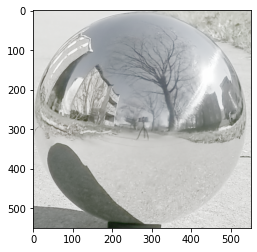

In [62]:
print('Naive HDR')
display_hdr_image(naive_hdr_image)

Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.665383278598632   Max ratio =  2.7496184788243125


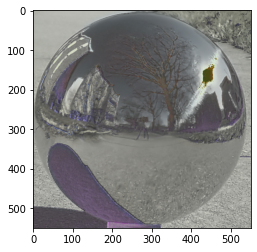

In [63]:
# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [64]:
# Sample random points from the mirror ball region
# Assumes mirror ball is perfectly inscribed inside square image
# Image has dimensions H x W x 3 (we must take all channels for a pixel, of course) 
# P is number of pixels to sample
# Returns list of pixel coordinates (tuples of length 2)
def get_random_pixels(H, W, P):
  all_pixels = []
  for i in range(H):
    for j in range(W):
      all_pixels.append((i, j))
  return random.sample(all_pixels, P)

# return 3 x N x P array to feed into g function
# note: only N x P will be fed in (one layer at a time)
def get_NP_array(ldr_images, pixels):
  N = len(ldr_images)
  P = len(pixels)
  NP_array = np.zeros((3, N, P))
  for i in range(3):
    for j in range(N):
      for k in range(P):
        NP_array[i][j][k] = ldr_images[j][pixels[k][0]][pixels[k][1]][i]
  return np.int64(NP_array)


In [65]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    
    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE

    # We will use 10000 pixels for gsolve
    P = 10000
    sample_pixels = get_random_pixels(H, W, P)
    log_exposure_times = np.log(exposure_times)
    ldr_images_clean = clean_ldr_images(ldr_images)
    NP_array = get_NP_array(ldr_images_clean, sample_pixels)

    hdr_image = np.ones((H, W, C))
    log_irradiances = np.zeros_like(ldr_images)
    gs = np.ones((C, 256))
    LEs = []

    # Get g-values
    # For each image, there will be a g-value for EACH channel
    weights = np.arange(256)
    weights = get_image_weights(weights)
    for i in range(C):
      g, LE = gsolve(NP_array[i], log_exposure_times, lm, weights)
      gs[i] = g
      LEs.append(LE)

    # reconstruct HDR image
    # use equation 6 from paper
    log_radiance = np.zeros((H, W, C))
    for c in range(C):
      # current image-channel
      for h in range(H):
        for w in range(W):
          uppersum = 0
          lowersum = 0
          for n in range(N):
            curr_pixel_value = ldr_images_clean[n, h, w, c]
            uppersum += get_image_weights(curr_pixel_value) * (gs[c][curr_pixel_value] - log_exposure_times[n])
            lowersum += get_image_weights(curr_pixel_value)
          log_radiance[h][w][c] = float(uppersum) / float(lowersum)

    hdr_image = np.exp(log_radiance)

    # calculate log irradiances
    for i in range(N):
      curr_irradiance = ldr_images[i] / exposure_times[i]
      curr_log_irradiance = np.log(curr_irradiance)
      log_irradiances[i] = curr_log_irradiance
      # log_irradiances[i] = log_radiance

    return hdr_image, log_irradiances, gs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log


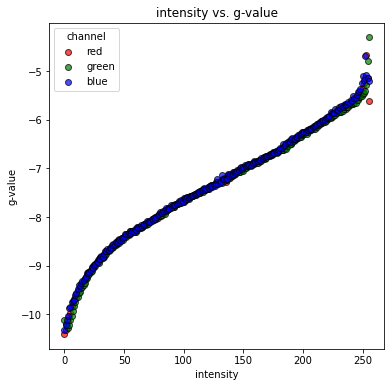

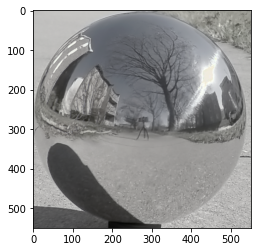

In [66]:
lm = 10
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)
fig = plt.figure(figsize=(6, 6))
plt.xlabel('intensity')
plt.ylabel('g-value')
plt.title('intensity vs. g-value')
plt.scatter(np.arange(256), g[0],
           linewidths=1, alpha=.7,
           edgecolor='k',
           c='red', label='red')
plt.scatter(np.arange(256), g[1],
           linewidths=1, alpha=.7,
           edgecolor='k',
           c='green', label='green')
plt.scatter(np.arange(256), g[2],
           linewidths=1, alpha=.7,
           edgecolor='k',
           c='blue', label='blue')
plt.legend(title='channel')
plt.show()

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.48564966732012194   Max ratio =  3.218209877178028


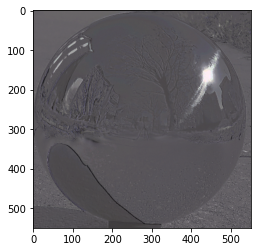

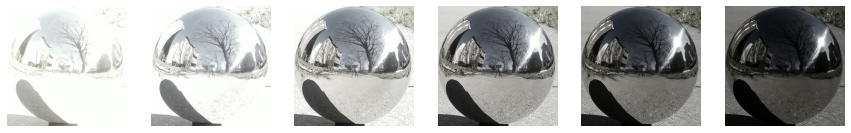

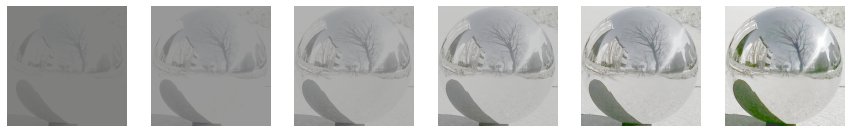

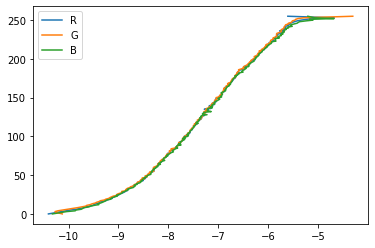

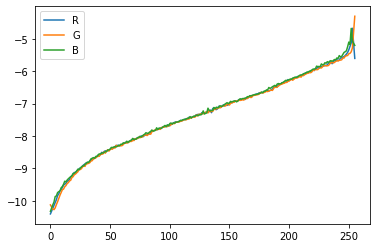

In [67]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  4.216 	avg RMS error =  0.454
weighted:	log range =  4.466 	avg RMS error =  0.407
calibrated:	log range =  5.396 	avg RMS error =  6.419


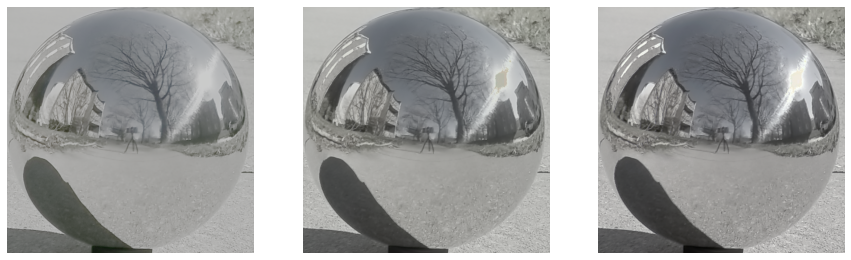

In [68]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [69]:
from re import U
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R

    # V is constant looking into the image
    V = np.float32(np.array([0,0,-1]))

    # N must be calculated based on reflection off sphere
    center = H / 2.0
    N = np.float32(np.zeros((H, W, C)))
    for h in range(H):
      for w in range(W):
        N[h][w][0] = (w - center) / (W / 2.0)
        N[h][w][1] = (h - center) / (H / 2.0)
        # must check if outside sphere of influence (no pun intended)
        if (N[h][w][0]**2 + N[h][w][1]**2 >= 1.0):
          N[h][w][0] = 1.0
          N[h][w][1] = 1.0
          N[h][w][2] = 1.0
        else:
          N[h][w][2] = np.sqrt(1.0 - N[h][w][0]**2 - N[h][w][1]**2)
        # normalize the normals
        N[h][w] = np.float32(N[h][w] / np.linalg.norm(N[h][w]))
        
    # R = V - 2 * dot(V,N) * N
    R = np.float32(np.zeros((H, W, C)))
    for h in range(H):
      for w in range(W):
        Nx = (np.float32(w) - center) / (W / 2.0)
        Ny = (np.float32(h) - center) / (H / 2.0)
        # must check if outside sphere of influence (no pun intended)
        if (Nx**2 + Ny**2 >= 1.0):
          R[h][w][0] = 1.0
          R[h][w][1] = 1.0
          R[h][w][2] = 1.0
        else:
          R[h][w] = np.float32(V - 2.0 * np.dot(V, N[h][w]) * N[h][w])    
        R[h][w] = np.float32(R[h][w] / np.linalg.norm(R[h][w]))   
    
    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image, N, R

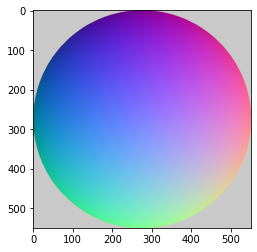

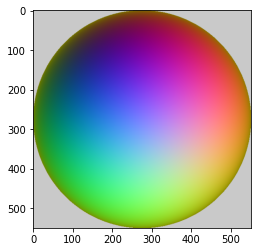

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


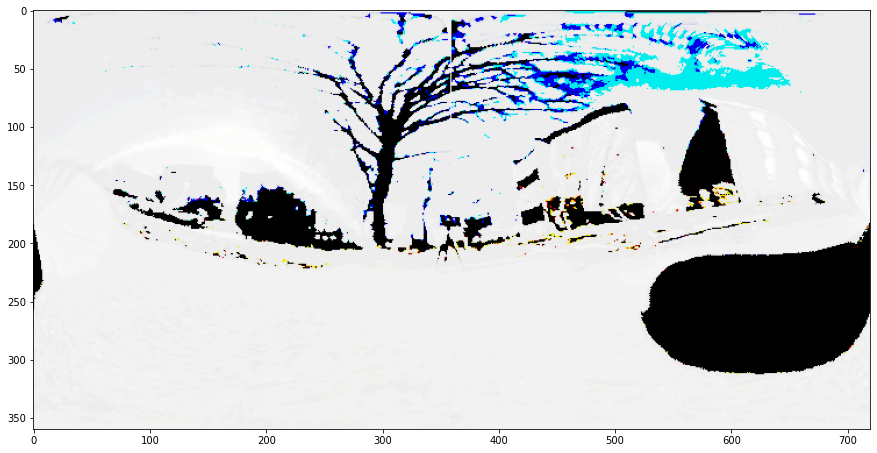

In [70]:
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
eq_image, N, R = panoramic_transform(hdr_mirrorball_image)
eq_image = np.abs(eq_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite. 

Note: images must be uploaded manually to the local images directory.

In [71]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/p41_rendered.png')
E = read_image('images/p41_empty_rendered.png')
M = read_image('images/p41_mask_rendered.png')
M = M > 0.5
I = read_image('images/p41_background.jpg')
I = cv2.resize(I, (M.shape[1], M.shape[0]))

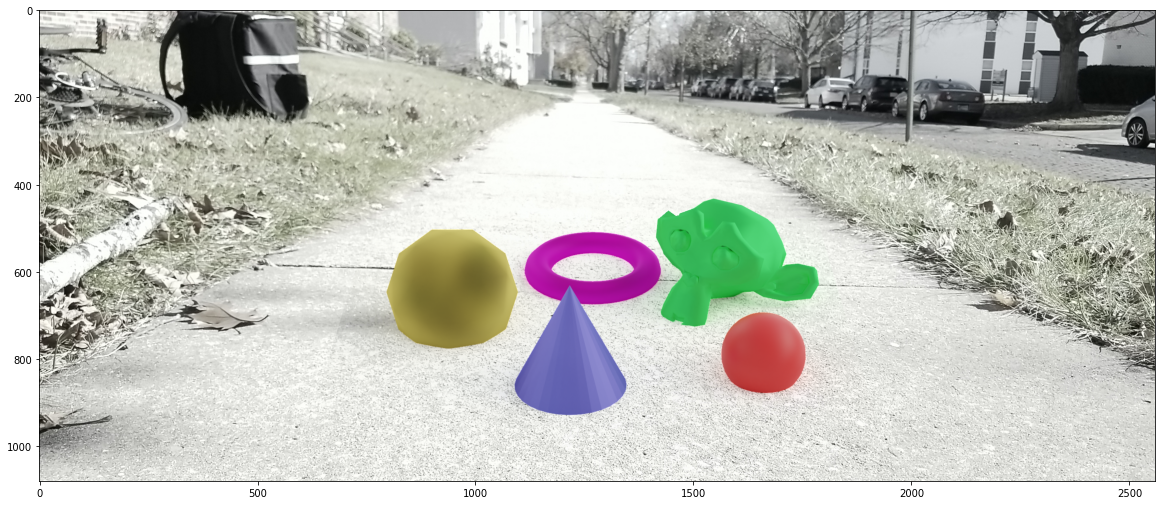

In [72]:
# TO DO: compute final composite
c = 1
M_actual = 1.0 - M
result = np.multiply(M_actual, O) + np.multiply(1.0-M_actual, I) + np.multiply(1.0-M_actual, O-E)*c

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite_1.png')

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 



Different objects using same light map. Features translucent skyscraper, glass golf trophy, Mandalorian helmet, 50s-era electric train with pantographs, monkey (default Blender object), and reflective teapot.

In [73]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/p42_rendered.png')
E = read_image('images/p42_empty_rendered.png')
M = read_image('images/p42_mask_rendered.png')
M = M > 0.5
I = read_image('images/p42_background.jpg')
I = cv2.resize(I, (M.shape[1], M.shape[0]))

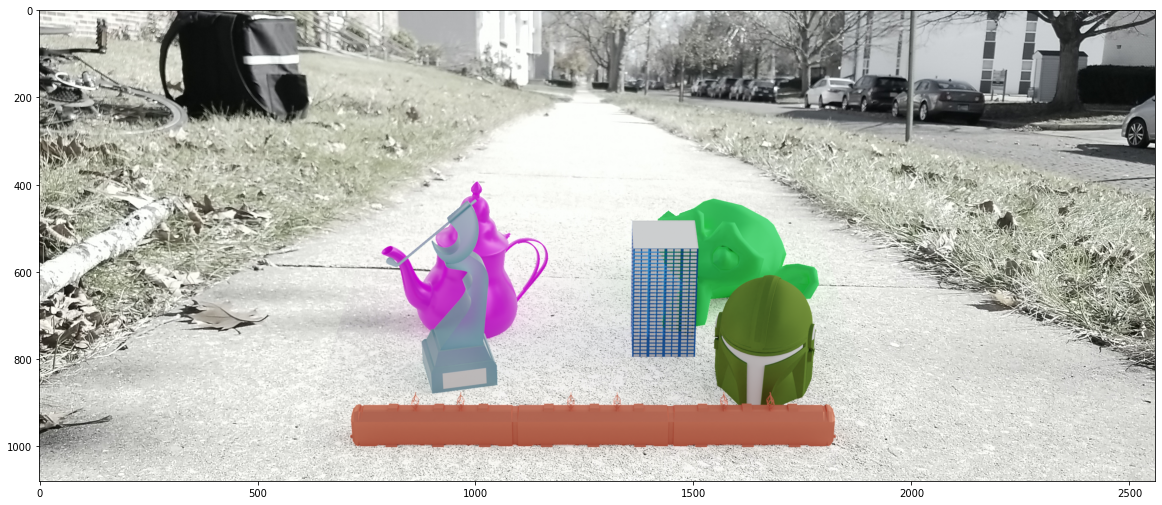

In [74]:
# TO DO: compute final composite
c = 1
M_actual = 1.0 - M
result = np.multiply(M_actual, O) + np.multiply(1.0-M_actual, I) + np.multiply(1.0-M_actual, O-E)*c

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite_2.png')

Same objects but different light map. I used my apartment as the setting, with the ball placed upon a desk. Lighting is radically different (a lot dimmer).

In [77]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/p43_rendered.png')
E = read_image('images/p43_empty_rendered.png')
M = read_image('images/p43_mask_rendered.png')
M = M > 0.5
I = read_image('images/p43_background.jpg')
I = cv2.resize(I, (M.shape[1], M.shape[0]))

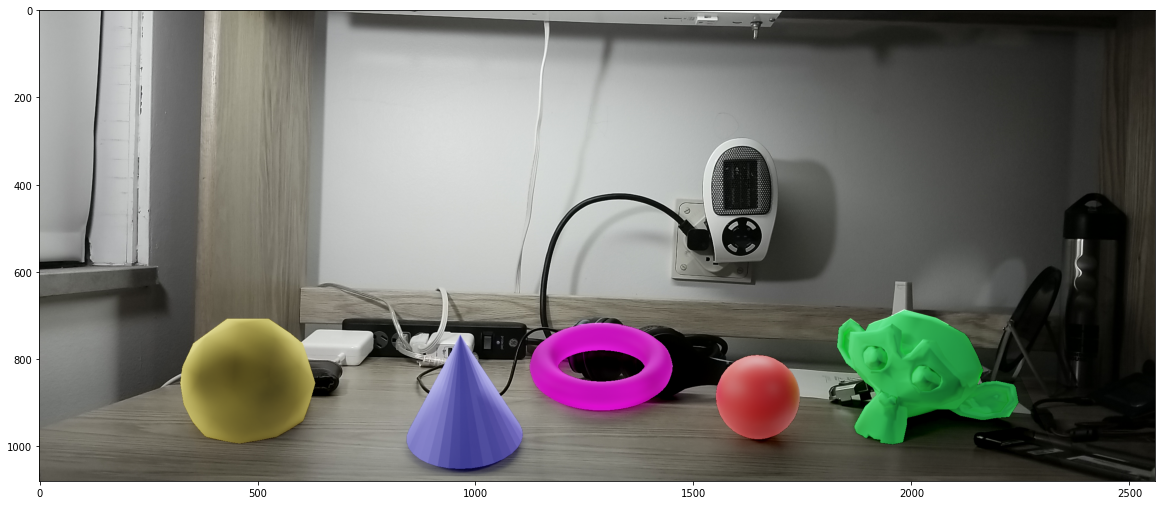

In [78]:
# TO DO: compute final composite
c = 1
M_actual = 1.0 - M
result = np.multiply(M_actual, O) + np.multiply(1.0-M_actual, I) + np.multiply(1.0-M_actual, O-E)*c

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite_3.png')